# Extracting ZIP (My computer's file system isn't working)

In [1]:
import zipfile
import os

def extract_zip_file(zip_file_path, destination_directory):
    """
    Extracts all contents of a zip file to a specified destination directory.

    Args:
        zip_file_path (str): The path to the zip file.
        destination_directory (str): The directory where the contents will be extracted.
    """
    os.makedirs(destination_directory, exist_ok=True)

    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(destination_directory)
        print(f"Successfully extracted '{zip_file_path}' to '{destination_directory}'")
    except zipfile.BadZipFile:
        print(f"Error: '{zip_file_path}' is not a valid zip file.")
    except FileNotFoundError:
        print(f"Error: Zip file not found at '{zip_file_path}'.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [ ]:
zip_file = "Brain-Tumor-Classification-DataSet-master.zip" ## From https://github.com/sartajbhuvaji/brain-tumor-classification-dataset
extract_to = "Brain_Tumor_Data"
extract_zip_file(zip_file, extract_to)

Successfully extracted 'Brain-Tumor-Classification-DataSet-master.zip' to 'Brain_Tumor_Data'


# Brain Tumor Classification

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('Brain_Tumor_Data/Brain-Tumor-Classification-DataSet-master'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Brain_Tumor_Data/Brain-Tumor-Classification-DataSet-master\Testing\glioma_tumor\image(1).jpg
Brain_Tumor_Data/Brain-Tumor-Classification-DataSet-master\Testing\glioma_tumor\image(10).jpg
Brain_Tumor_Data/Brain-Tumor-Classification-DataSet-master\Testing\glioma_tumor\image(100).jpg
Brain_Tumor_Data/Brain-Tumor-Classification-DataSet-master\Testing\glioma_tumor\image(11).jpg
Brain_Tumor_Data/Brain-Tumor-Classification-DataSet-master\Testing\glioma_tumor\image(12).jpg
Brain_Tumor_Data/Brain-Tumor-Classification-DataSet-master\Testing\glioma_tumor\image(13).jpg
Brain_Tumor_Data/Brain-Tumor-Classification-DataSet-master\Testing\glioma_tumor\image(14).jpg
Brain_Tumor_Data/Brain-Tumor-Classification-DataSet-master\Testing\glioma_tumor\image(15).jpg
Brain_Tumor_Data/Brain-Tumor-Classification-DataSet-master\Testing\glioma_tumor\image(16).jpg
Brain_Tumor_Data/Brain-Tumor-Classification-DataSet-master\Testing\glioma_tumor\image(17).jpg
Brain_Tumor_Data/Brain-Tumor-Classification-DataSet-master\T

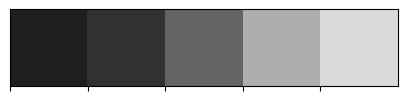

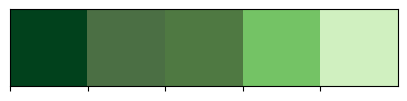

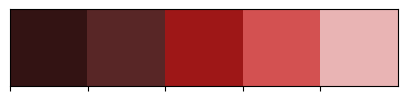

In [4]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

## Feature Engineering

In [6]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [50]:
X_train = []
y_train = []
image_size = 150

base_path = 'Brain_Tumor_Data/Brain-Tumor-Classification-DataSet-master'

for i in labels:
    folderPath = os.path.join(base_path, 'Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join(base_path, 'Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 347.05it/s]


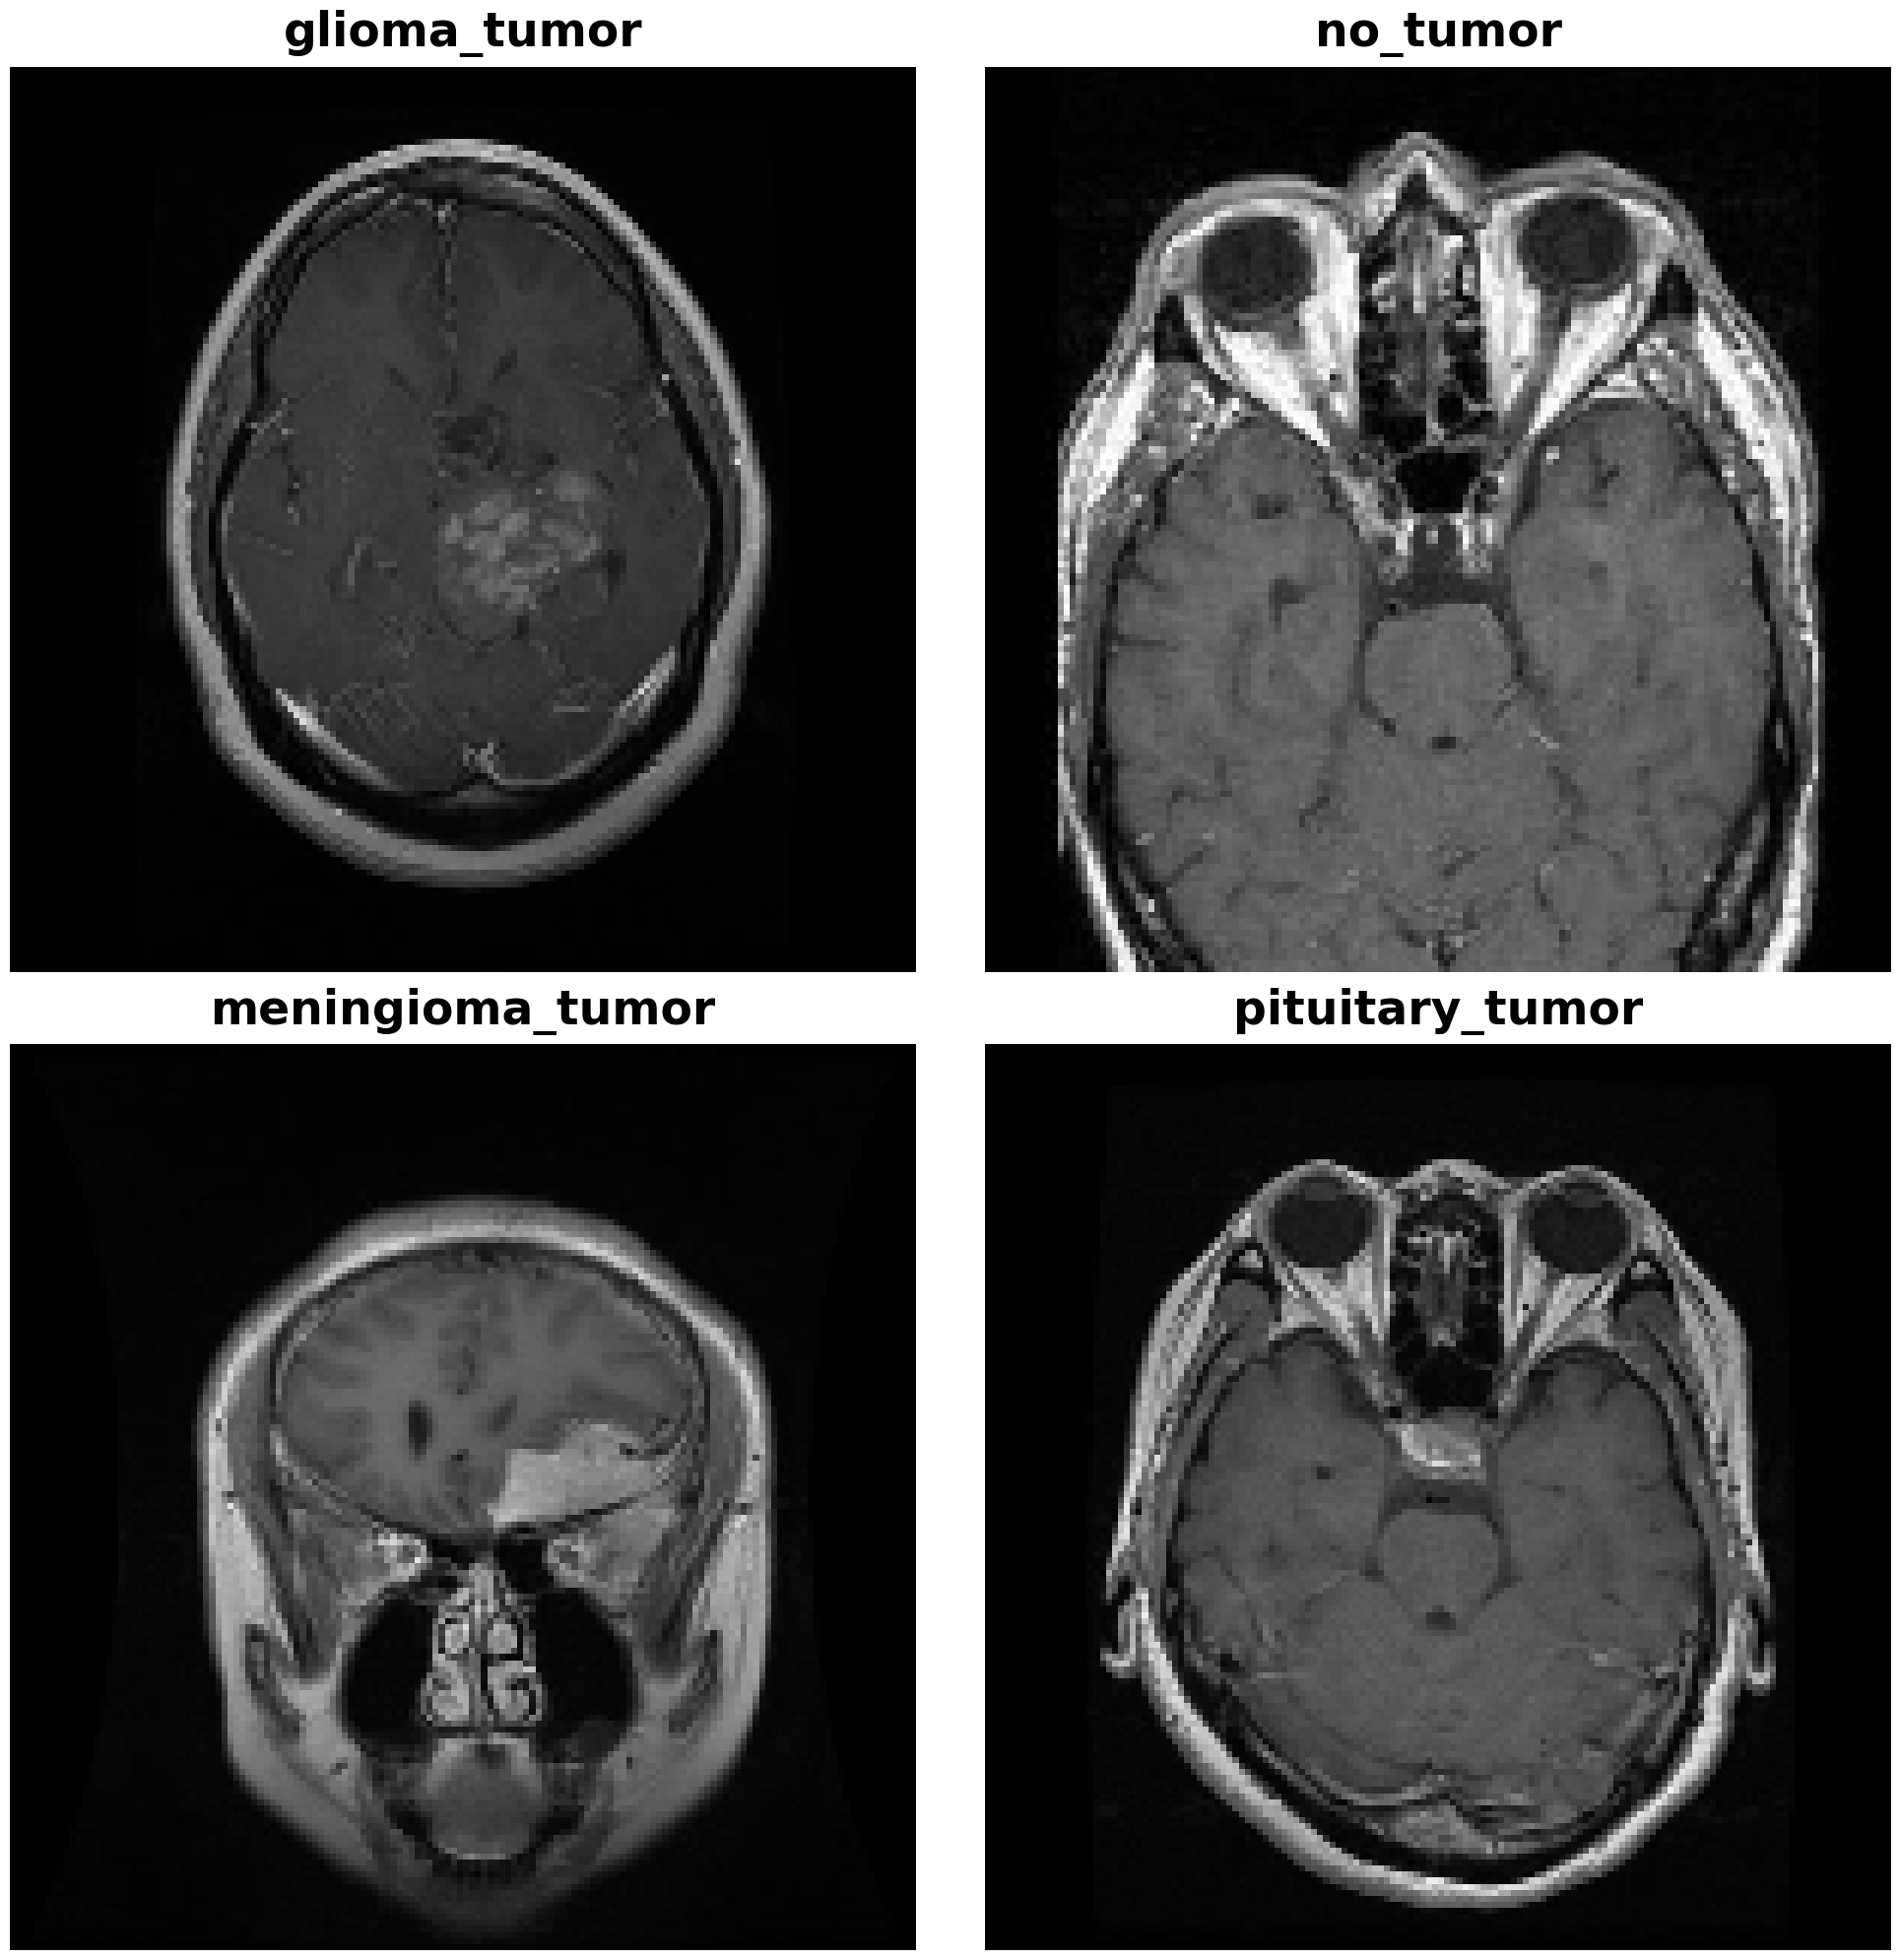

In [57]:
k = 0
fig, ax = plt.subplots(2, 2, figsize = (20, 20))
fig.text(s='Sample Image From Each Label',
         size = 5,
         y = 0.92,
         x = 0.3)

for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            row = k // 2
            col = k % 2
            ax[row, col].imshow(X_train[j])
            ax[row, col].set_title(y_train[j], 
                                   fontsize=34,
                                   fontweight='bold',
                                   pad=15)
            ax[row, col].axis('off')
            ax[row, col].set
            k += 1
            break
        j += 1

plt.tight_layout()
plt.show()

In [23]:
X_train, y_train = shuffle(X_train, y_train, random_state = 1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 1)


### One-Hot

In [24]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# Fitting

## Efficient Net

In [27]:
effnet = EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (image_size,image_size,3))

## Architecture

In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate = 0.5)(model)
model = tf.keras.layers.Dense(4, activation = 'softmax')(model)
model = tf.keras.models.Model(inputs = effnet.input, outputs = model)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 150, 150,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 150, 150,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 150, 150,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

## Compilation / Training

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5", monitor = "val_accuracy", save_best_only = True, mode = "auto", verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto', verbose =1)

In [32]:
history = model.fit(X_train, y_train, validation_split = 0.1, epochs = 12, verbose = 1, batch_size = 32,
                   callbacks = [tensorboard,checkpoint,reduce_lr])

Epoch 1/12
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7152 - loss: 0.7020
Epoch 1: val_accuracy improved from None to 0.83969, saving model to effnet.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.8101 - loss: 0.5049 - val_accuracy: 0.8397 - val_loss: 0.4807 - learning_rate: 0.0010
Epoch 2/12
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9252 - loss: 0.2136
Epoch 2: val_accuracy improved from 0.83969 to 0.87405, saving model to effnet.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9264 - loss: 0.2134 - val_accuracy: 0.8740 - val_loss: 0.5324 - learning_rate: 0.0010
Epoch 3/12
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9634 - loss: 0.1184
Epoch 3: val_accuracy did not improve from 0.87405
74/74 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9570 - loss: 0.1266 - val_accuracy: 0.8626 - val_loss: 0.5712 - learning_rate: 0.0010
Epoch 4/12
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9646 - loss: 0.1164
Epoch 4: val_accuracy did not improve from 0.87405

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
74/74 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9642 - loss: 0.1126 - val_accuracy: 0.8473 - val_loss: 0.8632 - learning_rate: 0.0010
Epoch 5/12
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9828 - loss: 0.0668
Epoch 5: val_accuracy improved from 0.87405 to 0.94656, saving model to effnet.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9847 - loss: 0.0556 - val_accuracy: 0.9466 - val_loss: 0.1221 - learning_rate: 3.0000e-04
Epoch 6/12
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9949 - loss: 0.0264
Epoch 6: val_accuracy did not improve from 0.94656
74/74 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9945 - loss: 0.0239 - val_accuracy: 0.9351 - val_loss: 0.1574 - learning_rate: 3.0000e-04
Epoch 7/12
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9975 - loss: 0.0131
Epoch 7: val_accuracy improved from 0.94656 to 0.96183, saving model to effnet.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9983 - loss: 0.0110 - val_accuracy: 0.9618 - val_loss: 0.1158 - learning_rate: 3.0000e-04
Epoch 8/12
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9972 - loss: 0.0090
Epoch 8: val_accuracy improved from 0.96183 to 0.96565, saving model to effnet.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9966 - loss: 0.0109 - val_accuracy: 0.9656 - val_loss: 0.0769 - learning_rate: 3.0000e-04
Epoch 9/12
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9992 - loss: 0.0078
Epoch 9: val_accuracy improved from 0.96565 to 0.97710, saving model to effnet.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9987 - loss: 0.0069 - val_accuracy: 0.9771 - val_loss: 0.0774 - learning_rate: 3.0000e-04
Epoch 10/12
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9997 - loss: 0.0044
Epoch 10: val_accuracy did not improve from 0.97710
74/74 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9987 - loss: 0.0089 - val_accuracy: 0.9656 - val_loss: 0.1120 - learning_rate: 3.0000e-04
Epoch 11/12
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9923 - loss: 0.0258
Epoch 11: val_accuracy did not improve from 0.97710

Epoch 11: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
74/74 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9940 - loss: 0.0188 - val_accuracy: 0.9656 - val_loss: 0.1202 - learning_rate: 3.0000e-04
Epoch 12/12
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9978 - loss: 0.0069
Epoch 12: val_accuracy did not improve from 0.97710
74/74 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9970 - loss: 0.0089 - val_accura

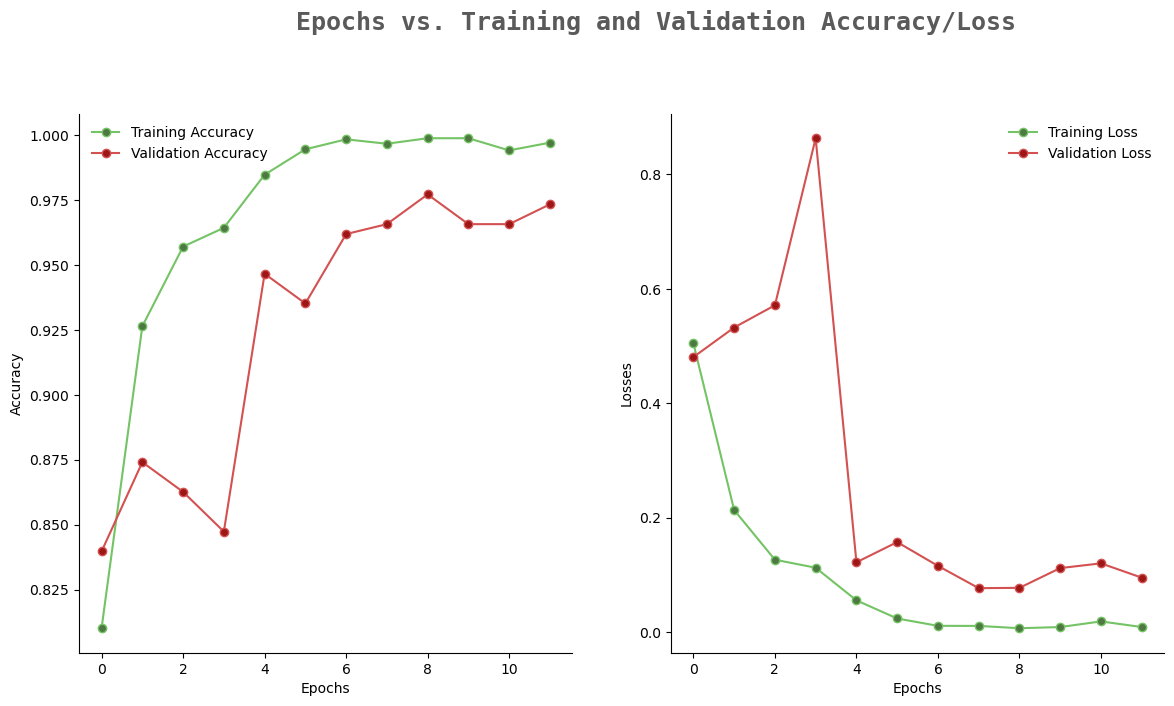

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss', size = 18, fontweight ='bold',
             fontname = 'monospace', color = colors_dark[1], y = 1, x = 0.28, alpha = 0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker = 'o', markerfacecolor = colors_green[2], color = colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o', markerfacecolor = colors_red[2], color = colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker = 'o', markerfacecolor = colors_green[2], color = colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker = 'o', markerfacecolor = colors_red[2], color = colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon = False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Losses')

fig.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step


In [43]:
len(X_test)

653

In [35]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       183
           1       0.98      1.00      0.99        96
           2       0.96      0.98      0.97       187
           3       0.99      0.98      0.99       187

    accuracy                           0.98       653
   macro avg       0.98      0.98      0.98       653
weighted avg       0.98      0.98      0.98       653



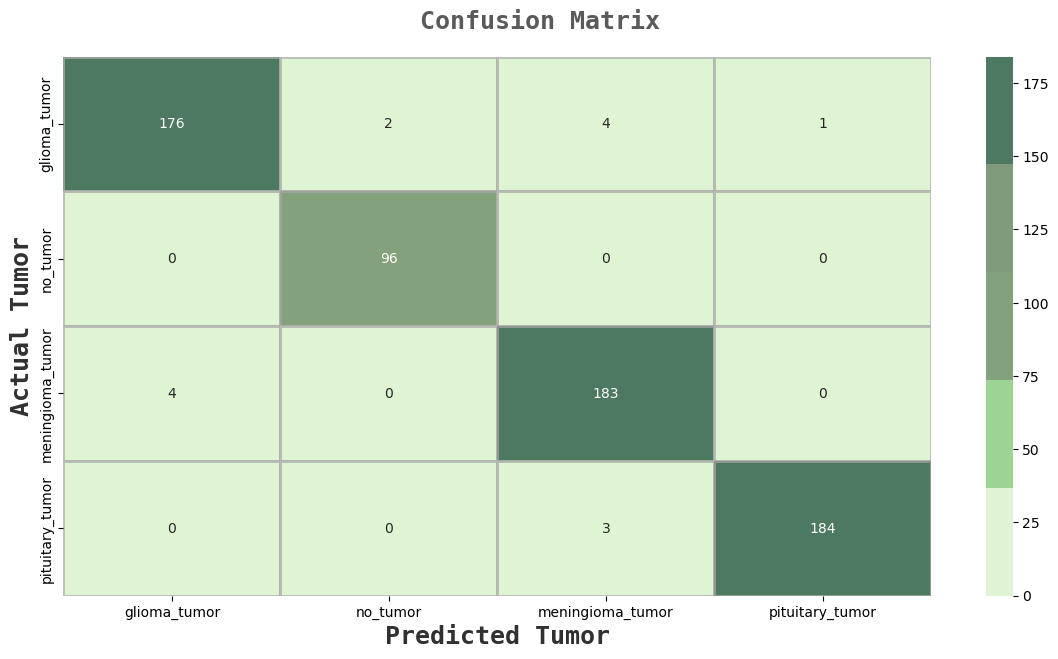

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new, pred), ax = ax, xticklabels = labels, yticklabels = labels, annot = True,
           cmap = colors_green[::-1], alpha = 0.7, linewidths = 2, linecolor = colors_dark[3], fmt = 'd')
fig.text(s = 'Confusion Matrix', size = 18, fontweight = 'bold',
             fontname = 'monospace', color = colors_dark[1], y = 0.92, x = 0.38, alpha = 0.8)

ax.set_xlabel('Predicted Tumor', fontsize = 18, fontweight = 'bold', fontname = 'monospace', color = colors_dark[1])
ax.set_ylabel('Actual Tumor', fontsize = 18, fontweight = 'bold', fontname = 'monospace', color = colors_dark[1])

plt.show()